# Trouver sa position en connaissant la position des balises

Nous nous situons dans le cadre de la coupe de France de robotique 2019. On a un robot capable de se mouvoir sur une table de 2 mètres sur 3. On a aussi un LiDAR qui peut prendre des mesures à 360°. On peut donc observer notre environnement immédiat dans un plan donné. Et si on retrouvait sa propre position sur la table ?

## Environnement de travail

On importe ce qu'il faut : 
- *numpy* pour faire du calcul matriciel, 
- *matplolib* avec *pyplot* pour afficher des graphiques.


In [1]:
import numpy as np
import matplotlib.pyplot as pl
pl.figure(figsize=(15,13))

# %matplotlib inline
%matplotlib notebook

On importe depuis la racine le code du projet nécessaire pour ce *notebook*.

In [2]:
from lidarproc.main.constants import *
import lidarproc.main.clustering as clus
import lidarproc.main.data_cleansing as dacl
import lidarproc.main.output_rendering as outr
from lidarproc.retrieve_realistic_measures import get_table_measures
import lidarproc.check_hough as chh
import lidarproc.check_clustering as chc
from lidarproc.main.geometry import Point, Vector
import lidarproc.main.conversion as conv
from lidarproc.main.table import Square, Table

## Avec de vraies données

In [3]:
from lidarproc.plot_measures import display_polar_measures
from lidarproc.retrieve_realistic_measures import get_05_05_2019_lidar_measures

On affiche les données légèrement remaniées. Ce sont des mesures prises par le LiDAR **RPLIDAR A3**.

<IPython.core.display.Javascript object>


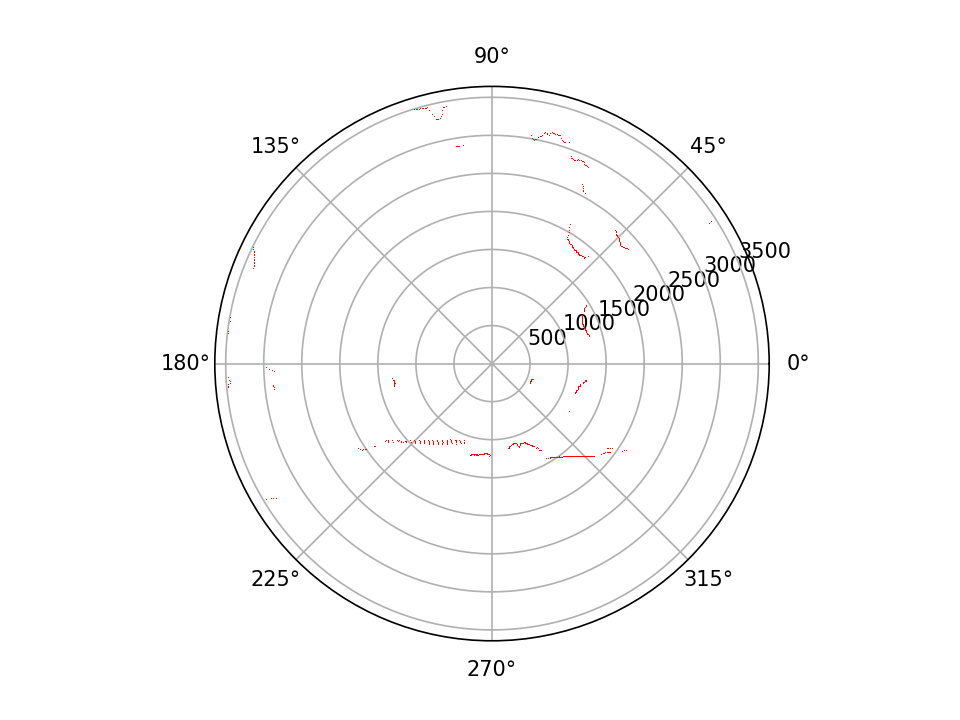

In [4]:
%matplotlib notebook

samples = ["3"]
measures = get_05_05_2019_lidar_measures(samples[0])
one_turn_measure = dacl.filter_points(measures[0], 100)
# one_turn_measure = conv.change_angle_referentiel(one_turn_measure, is_rad=False, convert_to_rad=False, supplementary_angle=90)
display_polar_measures(one_turn_measure)


On peut y voir le chauffage derrière le robot.

#### Chargement des mesures

In [5]:
samples = ["3"]
measures = get_05_05_2019_lidar_measures(samples[0])
one_turn_measure = dacl.filter_points(measures[0], 100)
one_turn_measure = outr.one_turn_to_cartesian_points(one_turn_measure)

#### Changement de repère

On passe du repère du robot (oui, on prend les mesures depuis le robot) au repère de la table (oui, le haut-niveau réfléchit en absolu). Pour cela, il faut avoir les coordonnées du robot sur la table et l'orientation qu'il a.

In [6]:
def change_basis(rp, ori, measures):
#     measures = outr.one_turn_to_cartesian_points(measures)
    new_measures = []
    for measure in measures:
        p = Point(measure[0], measure[1])
        p.rotate(-ori)
        new_measure = p + rp
        new_measures.append([new_measure.x, new_measure.y])
    return new_measures

Lorsqu'on a pris les mesures, on considérait le robot comme se situant en position (1210, 1400) avec une orientation de $\pi$ radians. Il est à noter que comme le centre du robot n'est pas au niveau du LiDAR, il faut prendre en compte ce décalage. En l'occurence il y a un décalage de 12cm vers l'arrière du robot.

In [7]:
%matplotlib notebook

# robot_position = Point(1210-120, 1400)
robot_position = Point(1210+120, 1400)
orientation = -np.pi/2

# robot_position = Point(-1210-120, 1400)
# orientation = 0

In [8]:
new_one_turn_measure = change_basis(robot_position, orientation, one_turn_measure)

### Comparaison entre les mesures et le modèle

On affiche la table, les bordures des balises, et les mesures dans le repère de la table.

<IPython.core.display.Javascript object>


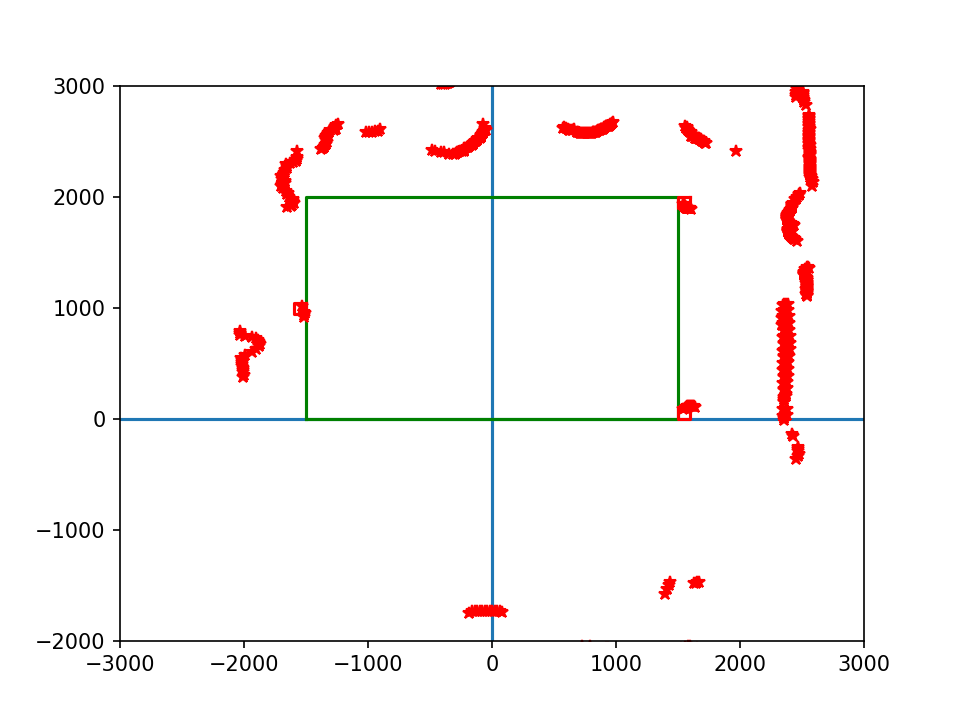

In [9]:
# table instantiation
table = Table()

table_beacon_1 = Square([Point(-1500 - 100, 2000), Point(-1500, 2000), Point(-1500, 2000 - 100),
                   Point(-1500 - 100, 2000 - 100)])
table_beacon_2 = Square([Point(1500, 1000 + 50), Point(1500 + 100, 1000 + 50), Point(1500 + 100, 1000 - 50),
                   Point(1500, 1000 - 50)])
table_beacon_3 = Square([Point(-1500 - 100, 0 + 100), Point(-1500, 0 + 100), Point(-1500, 0), Point(-1500 - 100, 0)])

table_beacon_1.take_symmetric()
table_beacon_2.take_symmetric()
table_beacon_3.take_symmetric()

table.add_square_obstacle(table_beacon_1)
table.add_square_obstacle(table_beacon_2)
table.add_square_obstacle(table_beacon_3)

table.add_edge_point(Point(-1500, 0))
table.add_edge_point(Point(1500, 0))
table.add_edge_point(Point(1500, 2000))
table.add_edge_point(Point(-1500, 2000))

table.init_plot()

table.plot_edges()
table.plot_obstacles()

xx = []
yy = []
for x, y in new_one_turn_measure:
    xx.append(x)
    yy.append(y)

pl.plot(xx, yy, 'r*')

table.plot()

---------------------
Par Clément Besnier, [www.clementbesnier.fr.](https://www.clementbesnier.fr)